# Global indicator project - Phoenix, Arizona

## Pandana network accessibility - amenities
This notebook uses [pandana](https://udst.github.io/pandana/network.html) to download street network and points-of-interest data from OpenStreetMap and then calculate network accessibility to the points of interest. 
Learn from example [here](https://github.com/gboeing/urban-data-science/blob/59afcff905649c5f8d1f8256ec37f28496e0c740/20-Accessibility-Walkability/pandana-accessibility-demo-simple.ipynb)

Note: pandana currently only runs on Python 2.

In [91]:
import matplotlib.pyplot as plt
import numpy as np
import requests
import pandas as pd
import geopandas as gpd
import os
import time 

import config

#import pandana library
import pandana
from pandana.loaders import osm
%matplotlib inline

In [92]:
suffix = '_201905'

place = 'Phoenix, Arizona, USA'

In [93]:
Phx_osm_shape = gpd.GeoDataFrame.from_file('../data/OSM/Phoenix, Arizona, USA_buffered_201905/Phoenix, Arizona, USA_buffered_201905.shp')

In [94]:
Phx_osm_shape

,bbox_east,bbox_north,bbox_south,bbox_west,place_name,geometry
0,-111.9255201,33.9183794,33.2903739,-112.3240289,"Phoenix, Maricopa County, Arizona, USA","POLYGON ((-112.4316750615756 33.5091678244802,..."


## Set up configuration 

In [95]:
# configure search at a max distance of 1 km for up to the 10 nearest points-of-interest
shop = ['supermarket', 'convenience']
distance = 1000
num_pois = 10
num_categories = len(shops) + 1 #one for each amenity, plus one extra for all of them combined

# bounding box as a list of llcrnrlat, llcrnrlng, urcrnrlat, urcrnrlng
bbox = [33.29, -112.32, 33.92, -111.93] #lat-long bounding box for Phx

In [96]:
# configure filenames to save/load POI and network datasets
net_filename = '../data/OSM/{}_network.h5'.format(place[0:4])
poi_filename = '../data/OSM/{}_pois_{}.csv'.format(place[0:4], '_'.join(shop))

In [97]:
# keyword arguments to pass for the matplotlib figure
bbox_aspect_ratio = (bbox[2] - bbox[0]) / (bbox[3] - bbox[1])
fig_kwargs = {'facecolor':'w', 
              'figsize':(10, 10 * bbox_aspect_ratio)}

# keyword arguments to pass for scatter plots
plot_kwargs = {'s':5, 
               'alpha':0.9, 
               'cmap':'viridis_r', 
               'edgecolor':'none'}

# network aggregation plots are the same as regular scatter plots, but without a reversed colormap
agg_plot_kwargs = plot_kwargs.copy()
agg_plot_kwargs['cmap'] = 'viridis'

# keyword arguments to pass for hex bin plots
hex_plot_kwargs = {'gridsize':60,
                   'alpha':0.9, 
                   'cmap':'viridis_r', 
                   'edgecolor':'none'}

# keyword arguments to pass to make the colorbar
cbar_kwargs = {}

# keyword arguments to pass to basemap
bmap_kwargs = {}

# color to make the background of the axis
bgcolor = 'k'

## Download points of interest (POIs) from OSM
What amenities are considered for daily living pois? - [OSMtag](https://taginfo.openstreetmap.org/keys/amenity): shop=supermarket, convenience

In [98]:
start_time = time.time()
if os.path.isfile(poi_filename):
    # if a points-of-interest file already exists, just load the dataset from that
    pois = pd.read_csv(poi_filename)
    method = 'loaded from CSV'
else:   
    # otherwise, query the OSM API for the specified amenities within the bounding box 
    osm_tags = '"shop"~"{}"'.format('|'.join(shop))
    pois = osm.node_query(bbox[0], bbox[1], bbox[2], bbox[3], tags=osm_tags)
    
    # drop any that aren't just 'shop' then save to CSV
    pois = pois[pois['shop'].isin(shop)]
    pois.to_csv(poi_filename, index=False, encoding='utf-8')
    method = 'downloaded from OSM'
    
print('{:,} POIs {} in {:,.2f} seconds'.format(len(pois), method, time.time()-start_time))
pois[['shop', 'name', 'lat', 'lon']].head()

397 POIs downloaded from OSM in 1.04 seconds


,shop,name,lat,lon
id,,,,
158170307,supermarket,Safeway,33.488551,-112.081794
194872171,convenience,7-Eleven,33.480013,-112.029747
315987032,supermarket,Fry's Marketplace,33.321899,-111.930303
316912138,supermarket,Fry's Food & Drug,33.379098,-111.976857
319992591,convenience,NaN,33.348719,-111.953919


## Download street network from OSM

In [99]:
start_time = time.time()
if os.path.isfile(net_filename):
    # if a street network file already exists, just load the dataset from that
    network = pandana.network.Network.from_hdf5(net_filename)
    method = 'loaded from HDF5'
else:
    # otherwise, query the OSM API for the street network within the specified bounding box
    network = osm.pdna_network_from_bbox(bbox[0], bbox[1], bbox[2], bbox[3])
    method = 'downloaded from OSM'
    
    # identify nodes that are connected to fewer than some threshold of other nodes within a given distance
    lcn = network.low_connectivity_nodes(impedance=1000, count=10, imp_name='distance')
    network.save_hdf5(net_filename, rm_nodes=lcn) #remove low-connectivity nodes and save to h5
    
print('Network with {:,} nodes {} in {:,.2f} secs'.format(len(network.node_ids), method, time.time()-start_time))

Requesting network data within bounding box from Overpass API in 4 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](33.29000000,-112.12569713,33.60678952,-111.92998601);>;);out;'}"
Downloaded 47,460.0KB from www.overpass-api.de in 5.84 seconds
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](33.29000000,-112.32000000,33.60516335,-112.12163471);>;);out;'}"
Downloaded 27,349.7KB from www.overpass-api.de in 3.89 seconds
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedes

## Calculate accessibility to the amenity we retrieved

In [100]:
# precomputes the range queries (the reachable nodes within this maximum distance)
# so, as long as you use a smaller distance, cached results will be used
network.precompute(distance + 1)

In [101]:
# initialize a category for all amenities with the locations specified by the lon and lat columns
network.set_pois(category='all', maxdist=distance, maxitems=num_pois, x_col=pois['lon'], y_col=pois['lat'])

In [102]:
# searches for the n nearest amenities (of all types) to each node in the network
all_access = network.nearest_pois(distance=distance, category='all', num_pois=num_pois)

# it returned a df with the number of columns equal to the number of POIs that are requested
# each cell represents the network distance from the node to each of the n POIs
print('{:,} nodes'.format(len(all_access)))
all_access.head()

207,233 nodes


,1,2,3,4,5,6,7,8,9,10
id,,,,,,,,,,
41190548,608.900024,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0
41190554,580.231018,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0
41190566,1000.000000,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0
41190568,1000.000000,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0
41190571,1000.000000,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0


## Plot accessibility from each node to any amenity

Text(0.5,1,'Walking distance (m) to nearest supermarket and convenience shops around Phoenix')

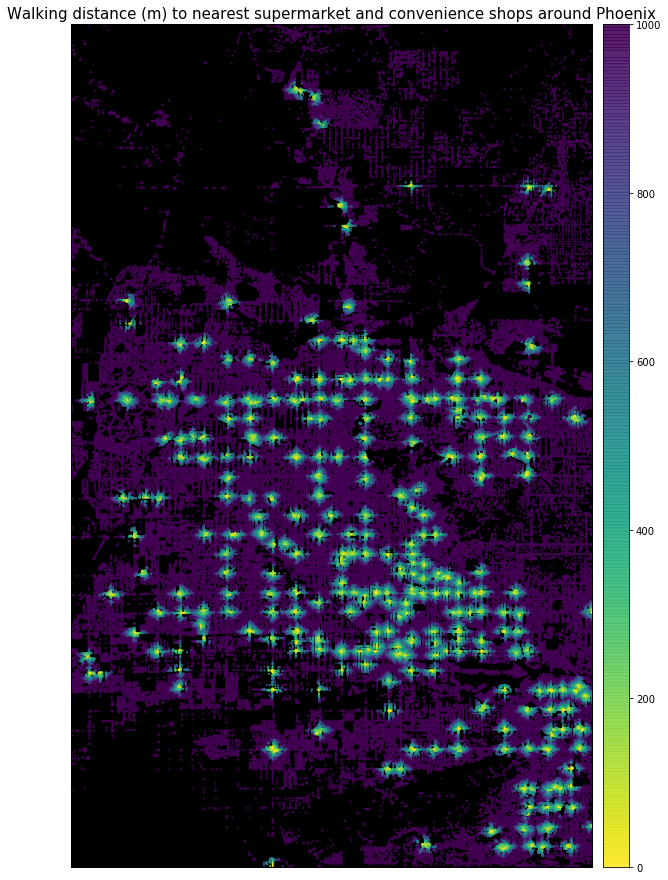

In [103]:
# distance to the nearest amenity of any type
n = 1
bmap, fig, ax = network.plot(all_access[n], bbox=bbox, plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs, bmap_kwargs=bmap_kwargs, cbar_kwargs=cbar_kwargs)
ax.set_facecolor(bgcolor)
ax.set_title('Walking distance (m) to nearest supermarket and convenience shops around Phoenix', fontsize=15)
#fig.savefig('images/accessibility-shop-phx.png', dpi=200, bbox_inches='tight')

Note: need to discuss search distance and the number of pois; how to aggregate the result and determine the accessibility score